# Minority Game Memory Dynamics


Compare two simulations one with fixed memory and one with a distribution of memory, we argue that the one with the distribution would lead to a more efficient equilibrium.  

## Discussion Points
- m can be zero?


**Make sure to include** `import allow_local_imports` on top of every notebook in `notebooks/` dir to be able to use `lib/` modules.

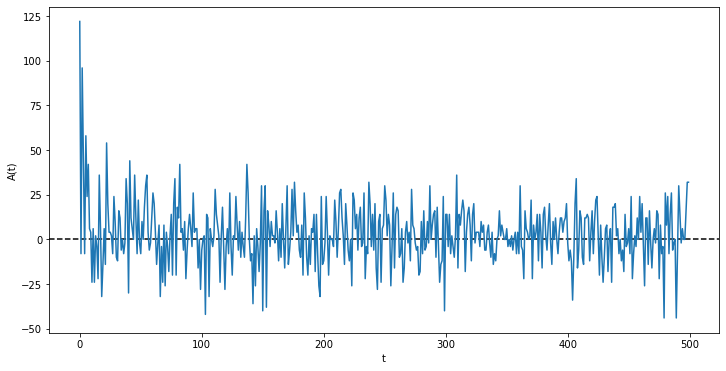

In [2]:
# Include this on top, as the first import 
# This must always be imported first. If you are restarting the notebook
# don't forget to run this cell first!
import allow_local_imports
# Use anything from lib package
# E.g.
from lib.functions import simulate_simple_game

simulate_simple_game()

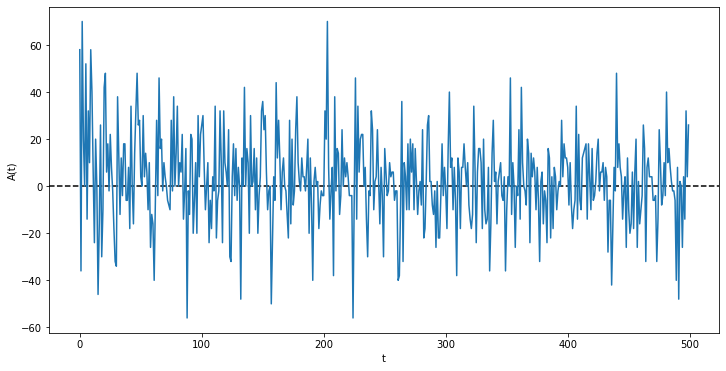

In [3]:
from lib.minority_game import MinorityGame
from lib.agents.agent import Agent, StrategyUpdatingAgent
from lib.agents.factory import AgentFactory
from lib.strategies import AlwaysOneStrategy, DefaultStrategy, FiftyFiftyStrategy
from lib.memory import UniformMemoryGenerator
from lib.plots import default_plot


times, attendances, mean_At, volatility_At = MinorityGame(
    n_agents=201,
    factory_dict={
        0.3: AgentFactory(
            Agent,
            agent_kwargs=dict(strategy_clss=[DefaultStrategy, DefaultStrategy]),
            memory_generator=UniformMemoryGenerator(m=3)
        ),
        0.5: AgentFactory(
            StrategyUpdatingAgent,
            agent_kwargs=dict(
                strategy_clss=[FiftyFiftyStrategy, DefaultStrategy, AlwaysOneStrategy],
                strategy_update_rate=0.8
            ),
            memory_generator=UniformMemoryGenerator(m=3)
        ),
        0.2: AgentFactory(
            Agent,
            agent_kwargs=dict(
                strategy_clss=[FiftyFiftyStrategy, DefaultStrategy]
            ),
            memory_generator=UniformMemoryGenerator(m=2)
        ),
    }
).simulate_game()

default_plot(times, attendances)

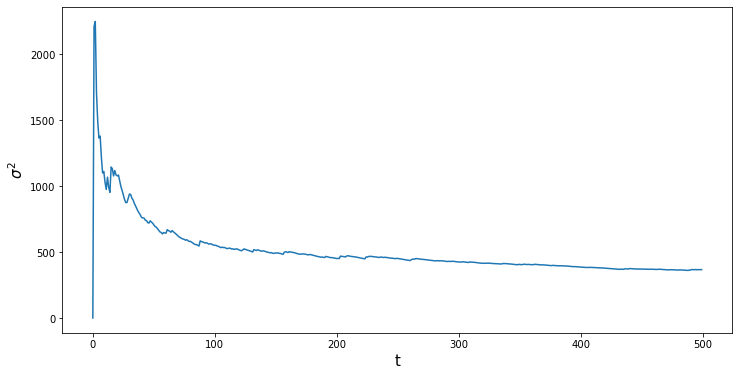

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(times, volatility_At, label=r"$\sigma^2$")
ax.set_xlabel("t",fontsize=15)
ax.set_ylabel(r"$\sigma^2$",fontsize=15)

plt.show()

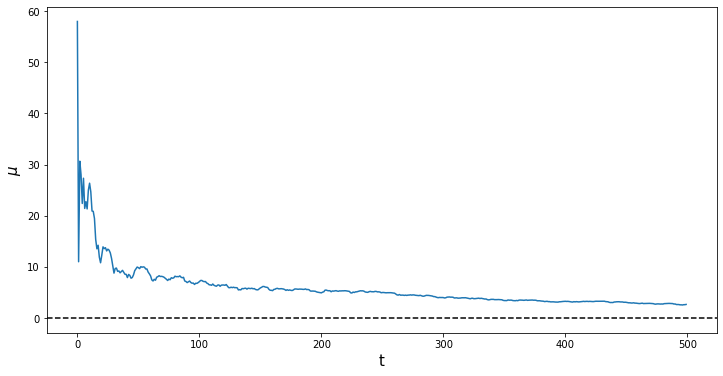

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.axhline(y=0, color="k", linestyle="--")
ax.plot(times, mean_At, label=r"$\mu$")
ax.set_xlabel("t",fontsize=15)
ax.set_ylabel(r"$\mu $",fontsize=15)

plt.show()

In [6]:
class BaseMemoryGenerator:
    """
    Abstract class that should be subclassed when implementing
    a new memory generator.
    """
    def __init__(self, m = 3, n_agents = 201, min_m = 0, max_m = 20):
        self.m = m
        self.n_agents = n_agents

    def generate(self, size):
        raise NotImplementedError
        
class DistributionMemoryGenerator(BaseMemoryGenerator):
    """
    Samples memory from a distribution
    (Memories are distributed by default normal distribution.)
    """

    def generate(self, n_agents, min_m = 1, max_m = 10):
        x = np.linspace(min_m, max_m, 1000)
        mean = np.mean(x)
        sd = np.std(x)
        y =  norm.pdf(x, mean, sd)
        sample = np.random.choice(x, n_agents, p=y/(sum(y))).astype(int)
        return sample

In [14]:
# function simultae _game returns times, attendances , mean_A_t, vol_A_t

m_g1 = 5
m_g2 = 3
g1_size = 0.3
g2_size = 0.7
n_agents = 501

times, attendances, _, volatility = MinorityGame(
    n_agents=n_agents,
    factory_dict={
        g1_size: AgentFactory(
            Agent,
            agent_kwargs=dict(strategy_clss=[DefaultStrategy, DefaultStrategy]),
            memory_generator=DistributionMemoryGenerator(m=m_g1,n_agents = n_agents)
        ),
        g2_size: AgentFactory(
            Agent,
            agent_kwargs=dict(strategy_clss=[DefaultStrategy, DefaultStrategy]),
            memory_generator=UniformMemoryGenerator(m_g2)
        )
    }
).simulate_game()

<ipython-input-20-e954ca2bff80>:15: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([11,12], labels=labels, loc='upper right')


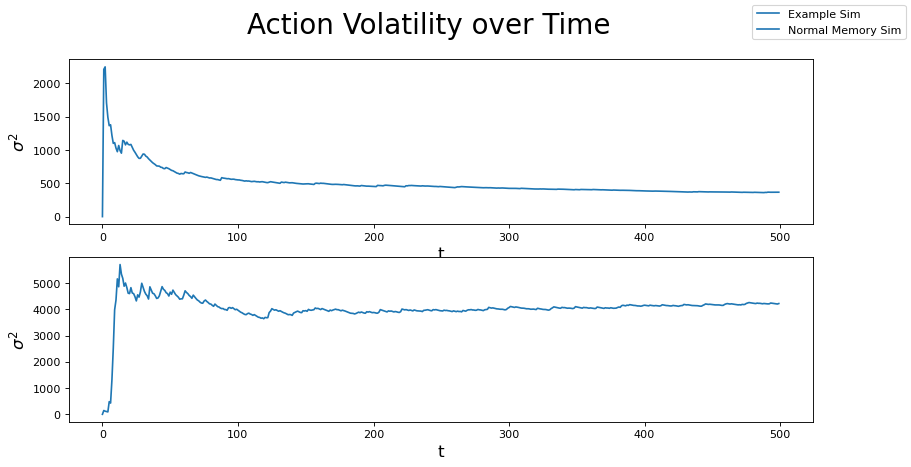

In [20]:
#fig, ax = plt.subplots(figsize=(12, 6))
fig,ax=plt.subplots(2,1,figsize=(12,6), dpi=80)
fig.suptitle('Action Volatility over Time', fontsize=25)

ax[0].plot(times, volatility_At, label=r"$\sigma^2$")
ax[0].set_xlabel("t",fontsize=15)
ax[0].set_ylabel(r"$\sigma^2$",fontsize=15)

#ax[1].axhline(y=0, color="k", linestyle="--")
ax[1].plot(times, volatility, label=r"$\sigma^2$")
#ax[1].plot(times, volatility_At, label=r"$\sigma^2$")
ax[1].set_xlabel("t",fontsize=15)
ax[1].set_ylabel(r"$\sigma^2$",fontsize=15)
labels=["Example Sim", "Normal Memory Sim"]
fig.legend([11,12], labels=labels, loc='upper right')
plt.show()

In [ ]:
import numpy as np
#import networkx as nx
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
from scipy.stats import norm

## Helper functions

In [ ]:
def integer_state(history):
    """
    maps a list of m combinations of 1s and -1s to a unique number
    INPUT| a list of the last m outputs of the game
    OUTPUT| a unique integer
    """
    state = 0
    p = len(history)-1
    for i in history:
        if i == 1:
            state += 2**p
        p -= 1
    return state
def maximum_index(score):
    """
    Returns the index of the maximum score (if more than one max, selects randomly)
    """
    maximos = np.argwhere(score == np.amax(score)).flatten()
    return np.random.choice(maximos)

def minority(A):
    """
    Return the winner action
    """
    if A < 0:
        return 1
    elif A > 0:
        return -1
    else:
        return 2*random.randint(0, 1)-1

def update_scores(N, S, A, strategies, state, scores, winner):
    for n in range(N):
        for s in range(S):
            if strategies[n][s][state] == winner:
                scores[n][s] += 1  # g[A(t)] = sign(A(t))
                #scores[n][s] += A
            else:
                scores[n][s] -= 1  # g[A(t)] = sign(A(t))
                #scores[n][s] += A
    return scores

def one_game(N, S, strategies, history, scores):
    actions = np.zeros(N)
    state = integer_state(history)
    for i in range(N):
        index_strategy = maximum_index(scores[i])
        actions[i] = strategies[i][index_strategy][state]
    A = np.sum(actions)
    winner = minority(A)
    scores = update_scores(N, S, A, strategies, state, scores, winner)
    history = np.concatenate((history[1:], [winner]))
    return A, history, scores

def one_simulation(N, S, M, T, imprime=10**8):
    history = 2*np.random.randint(2, size=M)-1
    strategies = 2*np.random.randint(2, size=(N, S, 2**M))-1
    scores = np.zeros((N, S))
    attendances = np.zeros(T)
    times = np.zeros(T)
    meanA = np.zeros(T)  # to control the convergence
    # simulation
    for t in range(T):
        if (t+1) % imprime == 0:
            print('         t={}/{}'.format(t+1, T))
        A, history, scores = one_game(N, S, strategies, history, scores)
        times[t] = t
        attendances[t] = A
        meanA[t] = np.mean(attendances[:t+1])  # mean of the attendance so far
    return times, attendances, meanA


In [ ]:
N1 = 501 #num of agents
S1 = 2 #strategy
M1 = 3 #memory
times, attendances, meanA = one_simulation(N1, S1, M1, T=5000, imprime = 500)

In [ ]:
history = 2*np.random.randint(2, size=M1)-1
strategies = 2*np.random.randint(2, size=(N1, S1, 2**M1))-1
print(history)
print(strategies)

In [ ]:
fig, ax = plt.subplots(figsize = (12,6))

ax.axhline(y=0, color='k', linestyle='--')
ax.plot(times, meanA, '-', label = r'$<A(t)>$')
ax.set_xlabel('t')
ax.set_ylabel('<A(t)>')